In [2]:
import sys
sys.path.insert(1, "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/")
import rijks_torch.learning_problems as lp
import rijks_torch.learning_problems.defaults as defs
from rijks_torch.data_loading import RijksDataloaders

import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [3]:
# Make sure model architecture corresponds to state_dict file (.pth)
getmodel_fun = lp.get_swin_b_problem
state_dict_file = "/home/vincent/Documenten/BachelorsProject/best_models/ots_type2_swin_b-best.pth"

# Make sure dataset corresponds to used model!
dataset_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/type/fullsize2"
jpg_path = "/home/vincent/Documenten/BachelorsProject/Rijksdata/jpg/"

In [4]:
# Getting dataset and model:
datloader = RijksDataloaders(
    ds_name=dataset_path,
    hist_path=dataset_path + "-hist.csv",
    img_dir=jpg_path,
    transforms={"all": defs.buildTransform(imnet_norm=True)},
    batch_size=2
)

model, dl = getmodel_fun(off_the_shelf=False, pretrained=False, dl=datloader)
model.load_state_dict(torch.load(state_dict_file, map_location=torch.device('cpu')))
model = model.eval()

/home/vincent/.local/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def getAllAttentionWeights(model, image):
    """ Getting all attention weights by adding forward hooks and feeding it an image """
    att_weighs = []

    # Don't know how to remove the hooks again, so doing it this way :-p
    model_copy = deepcopy(model)

    def add_to_att_weights(module, inp, outp):
        nonlocal att_weighs
        # Taking the mean of all attention heads, but could also be max or min
        att_weighs += [outp.detach().numpy()]
    
    for name, module in model_copy.named_modules():
        if "attn_drop" in name: # A timm thing. This only works for timm models ;-)
            module.register_forward_hook(add_to_att_weights)
    
    model_copy(image)
    
    return att_weighs

In [6]:
iterator = iter(dl.test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


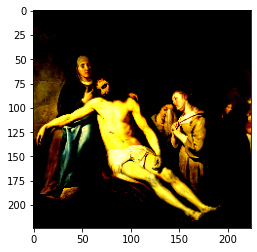

In [14]:
img = next(iterator)[0][0]
plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.show()

In [15]:
x = getAllAttentionWeights(model, img.unsqueeze(0))
del model
del iterator
del dl

In [9]:
path = "/home/vincent/Documenten/BachelorsProject/tmp/"

for idx, l in enumerate(x):
    np.save(path + "pre" + str(idx), l)
    print(f"{idx + 1} of {len(x)} done!")

1 of 24 done!
2 of 24 done!
3 of 24 done!
4 of 24 done!
5 of 24 done!
6 of 24 done!
7 of 24 done!
8 of 24 done!
9 of 24 done!
10 of 24 done!
11 of 24 done!
12 of 24 done!
13 of 24 done!
14 of 24 done!
15 of 24 done!
16 of 24 done!
17 of 24 done!
18 of 24 done!
19 of 24 done!
20 of 24 done!
21 of 24 done!
22 of 24 done!
23 of 24 done!
24 of 24 done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


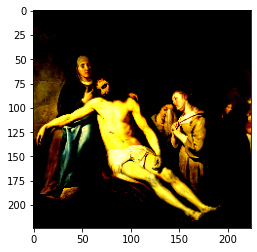

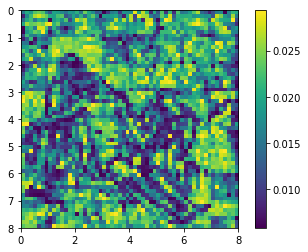

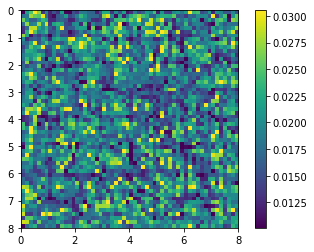

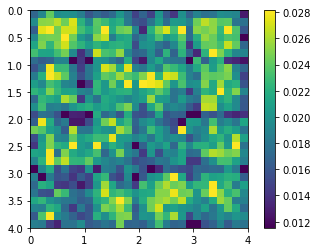

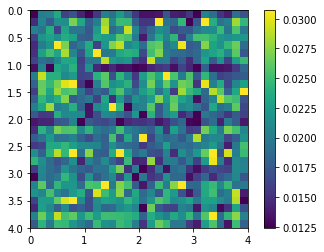

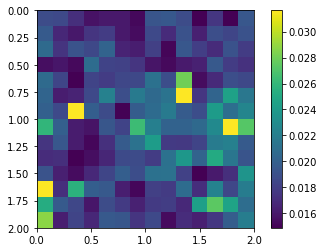

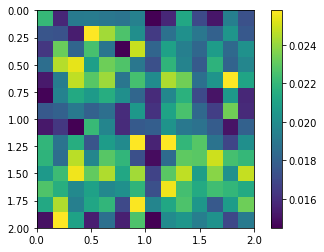

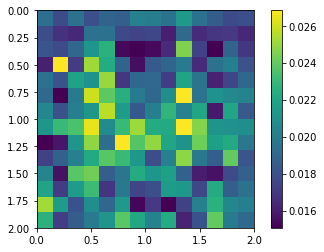

KeyboardInterrupt: 

In [29]:
def meanAttentionPerLayerTest(att_mat):
    
    sqrt_windows = int(np.sqrt(len(att_mat)))
    
    for idx, s in enumerate(att_mat):
        row = int(idx / sqrt_windows)
        col = int(idx % sqrt_windows)

        s_new = np.mean(s, axis=(0,1))
        s_new = np.reshape(s_new, (7,7))
        plt.imshow(s_new, extent=(col, col+1, row+1, row))
    plt.ylim(bottom=sqrt_windows, top=0)
    plt.xlim(left=0, right=sqrt_windows)

    plt.colorbar()

    plt.show()

plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.show()

for layer in x:
    meanAttentionPerLayerTest(layer)

In [16]:
import gc
gc.collect()

23721

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


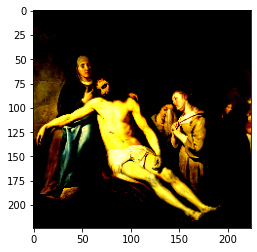

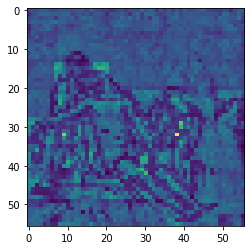

Did 0!


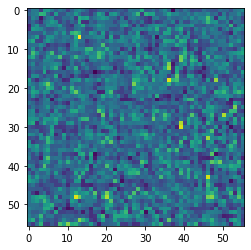

Did 1!


KeyboardInterrupt: 

In [28]:
def meanAttentionPerLayerTest(att_mat, shift=0):  
    m = np.mean(att_mat, axis=1, keepdims=True)

    batch, head, frm, to = m.shape
    
    sqrt_b = int(np.sqrt(batch))

    m = m.reshape((sqrt_b, sqrt_b, head, frm, to))

    # Turning it into a ViT-like attention thingy, with [heads, from, to]
    # instead of [window, head, win_from, win_to]:
    all_rows = []
    zero_layer = np.zeros((head, 49, 7 * sqrt_b, 7 * sqrt_b))
    for row_idx, row in enumerate(m):
        for col_idx, col in enumerate(row):
            tmp = zero_layer.copy()
            tmp[:, :, row_idx * 7: row_idx * 7 + 7, col_idx * 7: col_idx * 7 + 7] = col.reshape((head, 49, 7,7))
            all_rows += [tmp]
    m = np.concatenate(all_rows, axis=1)
    del all_rows

    # Inverting the window shifts:
    if shift != 0:
        m = np.roll(m, shift=shift, axis=(2,3))
    
    # plt.imshow(m.mean(axis=(0,1)))
    # plt.show()

    # Scale all to same size
    # Currently: heads, frm, sqrt_to, sqrt_to
    # Making it first, heads, sqrt_frm, sqrt_frm, sqrt_to, sqrt_to:
    s = m.shape
    repeats = int((3136 / s[1]) ** .5)
    sqrt_frm = int(s[1] ** .5)
    m = m.reshape(s[0], sqrt_frm, sqrt_frm, s[2], s[3])

    if repeats > 1:
        m = m.repeat(repeats=repeats, axis=1)
        m = m.repeat(repeats=repeats, axis=2)
        m = m.repeat(repeats=repeats, axis=3)
        m = m.repeat(repeats=repeats, axis=4)

    # Change the shape to how it works for ViTs as well
    s = m.shape
    m = m.reshape(s[0], s[1] * s[2], s[3] * s[4])
    m /= m.sum(axis=2, keepdims=True)

    return m.mean(axis=0)

plt.imshow(img.detach().numpy().transpose(1,2,0))
plt.show()

I = np.identity(3136)
result = I.copy()

for idx, layer in enumerate(x):
    A = meanAttentionPerLayerTest(layer, shift= 3 * int(idx % 2))
    dim = int(len(A[0]) ** .5)
    plt.imshow(A.mean(axis=0).reshape((dim, dim)))
    plt.show()
    A = 0.5 * A + 0.5 * I
    threshold = np.quantile(A, 0.99)
    A[A < threshold] = 0
    A /= np.sum(A)
    result = np.matmul(A, result)
    gc.collect()
    print(f"Did {idx}!")
    gc.collect()

plt.imshow(result.mean(axis=0).reshape(56,56))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


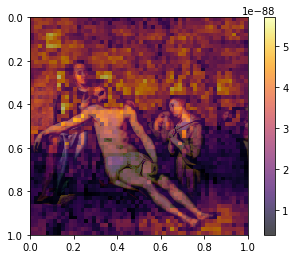

In [27]:
plt.imshow(img.detach().numpy().transpose(1,2,0), extent=(0, 1, 1, 0))
plt.imshow(result.mean(axis=0).reshape(56,56), extent=(0, 1, 1, 0), alpha=0.7, cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
model

# for layer in model.layers:
#     for idx, block in enumerate(layer.blocks):
#         print(f"block_{idx}: {int(224 / block.input_resolution[0])} - head: {block.num_heads}")

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=128, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
     